In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip as gz
import scipy
from importlib import reload
import glob
import tqdm
import itertools
from scipy.spatial.distance import cdist
import scanpy as sc

import sys
sys.path.append('/Genomics/pritykinlab/dillon/perturbseq/scripts/utils')
import dataloader
import umap_analysis
import reimplementation
import normalization
import adata_utils
from scipy.stats import mannwhitneyu

In [2]:
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.markersize"] = 5
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.edgecolor'] = 'dimgray'
plt.rcParams['figure.figsize'] = (7,7)

# Loading the data

In [3]:
import anndata as ad

# Load the AnnData objects
adata1 = ad.read_h5ad("/Genomics/pritykinlab/dillon/preprocessing_benchmarking/scripts/misc/pilot_results/HuTcellsCRISPRaPerturbSeq_Re-stimulated.h5ad")
adata2 = ad.read_h5ad("/Genomics/pritykinlab/dillon/preprocessing_benchmarking/scripts/misc/pilot_results/HuTcellsCRISPRaPerturbSeq_Resting.h5ad")

In [ ]:
adata1.obs['perturbation'] = adata1.obs['gene']
adata2.obs['perturbation'] = adata2.obs['gene']

import anndata as ad

# Load the AnnData objects
adata1.write_h5ad("/Genomics/pritykinlab/dillon/preprocessing_benchmarking/scripts/misc/pilot_results/SchmidtMarson2022_Re-stimulated.h5ad")
adata2.write_h5ad("/Genomics/pritykinlab/dillon/preprocessing_benchmarking/scripts/misc/pilot_results/SchmidtMarson2022_Resting.h5ad")

In [30]:
adata1.obs

,nCount_RNA,nFeature_RNA,orig.ident,condition,guide_id,gene,gene_category,crispr,donor,percent.mt,...,S.Score,G2M.Score,Phase,old.ident,CD4.CD8.Score,CD4.or.CD8,SCT_snn_res.0.4,seurat_clusters,cluster_name,activation.score
AACAACCGTCTGCATA-5,9224,3199,SeuratProject,Re-stimulated,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,5.951865,...,0.285249,-0.091633,S,SeuratProject,2.321928,CD4,2,2,2: Negative Regulators,-14.574648
GACTCTCTCCAAATGC-5,4823,2355,SeuratProject,Re-stimulated,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,10.491395,...,0.035622,-0.028818,S,SeuratProject,-2.496681,CD8,1,10,10: CD8 Common,158.064092
GTCATCCTCTTGAGCA-5,2658,1540,SeuratProject,Re-stimulated,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,11.211437,...,-0.169555,-0.157436,G1,SeuratProject,-2.060021,CD8,2,2,2: Negative Regulators,-51.062569
GTTGTAGGTTGGATCT-5,4112,2050,SeuratProject,Re-stimulated,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor1,11.892023,...,-0.216831,-0.140252,G1,SeuratProject,2.321928,CD4,0,14,14: CD4 Common,120.215364
TGGAGGATCAAATGAG-5,6537,2794,SeuratProject,Re-stimulated,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,5.705981,...,-0.326914,1.084080,G2M,SeuratProject,-1.584963,CD8,8,6,6: Proliferative (G2/M),72.955008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGTCCGTGGTTTAC-8,6381,2744,SeuratProject,Re-stimulated,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor1,2.570130,...,-0.010763,-0.235618,G1,SeuratProject,2.321928,CD4,0,14,14: CD4 Common,385.186010
GTCTAGAAGGCACTCC-8,7674,3183,SeuratProject,Re-stimulated,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor2,9.642950,...,0.180130,-0.098533,S,SeuratProject,-2.625253,CD8,0,14,14: CD4 Common,234.569534
TCCTAATCATACACCA-8,9470,3373,SeuratProject,Re-stimulated,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor1,11.003168,...,0.104045,0.351621,G2M,SeuratProject,-2.321928,CD8,3,9,"9: CCL3/4 High, IFNG Low",406.310974
AGACCCGGTATTGACC-8,10411,3591,SeuratProject,Re-stimulated,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor1,9.432331,...,0.096145,-0.060563,S,SeuratProject,2.875751,CD4,0,14,14: CD4 Common,363.622663


In [31]:
adata2.obs

,nCount_RNA,nFeature_RNA,orig.ident,condition,guide_id,gene,gene_category,crispr,donor,percent.mt,...,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CD4.CD8.Score,CD4.or.CD8,SCT_snn_res.0.5,seurat_clusters,cluster_name
GGGAGATAGACCGTTT-1,3432,1691,SeuratProject,Resting,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,4.924242,...,1731,-0.262716,-0.179993,G1,SeuratProject,-3.407993,CD8,1,8,8: CD8 Common
GACGCTGCATTGTCGA-1,3970,1749,SeuratProject,Resting,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor1,9.420655,...,1758,-0.200646,-0.136309,G1,SeuratProject,0.000000,Unassigned,0,6,6: CD4 Common
TTAATCCTCGTGCACG-1,4455,2233,SeuratProject,Resting,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,5.903479,...,2235,-0.082082,-0.168535,G1,SeuratProject,-3.169925,CD8,7,15,15: GNLY High
ACACGCGTCGACCTAA-1,4351,2113,SeuratProject,Resting,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,7.814296,...,2113,0.318414,0.022262,S,SeuratProject,-2.807355,CD8,3,13,13: Proliferating (G2/M)
CATCCACCATCGATGT-1,5092,2179,SeuratProject,Resting,ABCB10-1,ABCB10,Positive_IL2_only,perturbed,Donor2,7.010998,...,2179,-0.211240,-0.211237,G1,SeuratProject,-3.644984,CD8,1,8,8: CD8 Common
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AATGGAATCAAGCCTA-4,11216,3428,SeuratProject,Resting,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor1,12.820970,...,3032,-0.255092,-0.219153,G1,SeuratProject,3.503330,CD4,8,12,12: CD4 Effector Memory?
AACAAAGAGTGCAGGT-4,19302,4739,SeuratProject,Resting,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor1,9.957517,...,2665,0.331266,0.730707,G2M,SeuratProject,-1.584963,CD8,1,8,8: CD8 Common
TCTAACTCACGTCTCT-4,3176,1649,SeuratProject,Resting,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor2,19.773300,...,1746,-0.192950,-0.151690,G1,SeuratProject,-3.030323,CD8,9,1,1: Mitochondrial High
ATATCCTCATCAGTCA-4,5266,2266,SeuratProject,Resting,WT1-2,WT1,Positive_IFNg_only,perturbed,Donor2,12.590201,...,2266,-0.255719,-0.162620,G1,SeuratProject,2.321928,CD4,4,4,4: TCR High


In [32]:
adata2.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Panel a-c

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Ensure the directory exists
output_dir = "/Genomics/pritykinlab/dillon/preprocessing_benchmarking/scripts/misc/pilot_results/"
os.makedirs(output_dir, exist_ok=True)

# Define a custom color palette
def get_custom_gene_label(gene, genes_of_interest):
    return gene if gene in genes_of_interest else 'Other'

def plot_guide_proportions(adata, num_pcs, leiden_resolution):
    # Convert relevant data to a pandas DataFrame
    df = pd.DataFrame({
        'leiden_cluster': adata.obs[leiden_resolution],
        'perturbation': adata.obs['gene']
    })

    # Define the genes of interest and categorize others
    genes_of_interest = ['WT1', 'FOXD2']
    df['gene_category'] = df['perturbation'].apply(lambda x: x if x in genes_of_interest else 'Others')

    # Get counts of each guide category for each Leiden cluster
    counts = df.groupby(['leiden_cluster', 'gene_category']).size().unstack(fill_value=0)

    # Normalize the counts to get proportions
    proportions = counts.divide(counts.sum(axis=1), axis=0)

    # Define a color palette
    color_palette = {
        'WT1': sns.color_palette("husl", len(genes_of_interest))[0],
        'FOXD2': sns.color_palette("husl", len(genes_of_interest))[1],
        'Others': 'grey'
    }

    # Get the colors in the order of the columns in the proportions DataFrame
    colors = [color_palette[gene] for gene in proportions.columns]

    # Plot stacked bar chart with thinner bars
    ax = proportions.plot(kind='bar', stacked=True, figsize=(18, 10), color=colors, width=0.6, legend=False)

    # Remove x-axis label
    ax.set_xlabel('')

    # Add y-axis label with larger text
    ax.set_ylabel('')

    # Rotate x-axis tick labels to vertical
    ax.set_xticks(range(len(proportions.index)))
    ax.set_xticklabels(proportions.index, rotation=360, ha='center')

    # Adjust tick parameters for larger text
    plt.ylim(0, 1.07)
    plt.xticks([])  # Hide x-axis ticks
    plt.gca().set_xticklabels([])  # Hide x-axis labels
    # ax.tick_params(axis='x', which='both', labelsize=50, rotation=360)
    ax.tick_params(axis='y', which='both', labelsize=50)

    # Add the number of cells on top of each bar
    for i, (cluster, total_cells) in enumerate(counts.sum(axis=1).items()):
        ax.text(i, 1, f'{total_cells}', ha='center', va='bottom', fontsize=35, color='black')

    # Adjust the plot area to fit the legend and prevent clipping
    plt.tight_layout()

#     # Save the plot
#     plt.savefig(os.path.join(output_dir, f'Perturbations_proportions_{leiden_resolution}.png'))

    # Show the plot
    plt.show()



# Function to draw overlap UMAP for KO genes
def draw_overlap_UMAP_KO(adata, genes_of_interest, num_pcs):
    # Check if UMAP data is stored in adata
    if 'X_umap' not in adata.obsm.keys():
        raise ValueError("UMAP data not found in adata. Make sure UMAP embeddings are computed.")

    # Define a color palette for the genes of interest
    color_palette = sns.color_palette("husl", len(genes_of_interest))
    color_mapping = {gene: color for gene, color in zip(genes_of_interest, color_palette)}

    fig, ax = plt.subplots()

    # Plot the cells not in genes_of_interest (in light grey)
    other_cells = adata[~adata.obs['gene'].isin(genes_of_interest)]
    sc_other = ax.scatter(other_cells.obsm['X_umap'][:, 0], other_cells.obsm['X_umap'][:, 1], color='lightgray', s=50, label='Others')

    # Plot each group of interest with a unique color
    scatter_plots = []
    for gene in genes_of_interest:
        group = adata[adata.obs['gene'] == gene]
        sc = ax.scatter(group.obsm['X_umap'][:, 0], group.obsm['X_umap'][:, 1], color=color_mapping[gene], label=gene, s=50)
        scatter_plots.append(sc)

    ax.axis('off')  # Remove the axis

    # # Create the legend in the desired order
    # handles, labels = [sc_other] + scatter_plots, ['Others'] + genes_of_interest
    # ax.legend(handles, labels, loc='upper right', fontsize=10)

    plt.show()


############################## Main function for all plots #################################################
def default_pipeline(your_adata, num_hvg, num_pcs, resolutions):
    print(f"############################ num_pcs: {num_pcs}; num_hvg: {num_hvg} ############################")
    adata = your_adata.copy()
    sc.pp.normalize_total(adata)
    adata.layers['raw_norm'] = adata.X.copy()
    sc.pp.log1p(adata)
    if num_hvg is not None:
        sc.pp.highly_variable_genes(adata, n_top_genes=num_hvg, flavor='seurat')
        adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=num_pcs)
    sc.pp.neighbors(adata, n_pcs=num_pcs)  # Use the same number of PCs for neighbors
    sc.tl.umap(adata)
    
    resolutions = resolutions
    for res in resolutions:
        sc.tl.leiden(adata, resolution=res)
        adata.obs[f'leiden_{res}'] = adata.obs['leiden']

    # # Save UMAP plots for Leiden clusters
    for res in resolutions:
        sc.pl.umap(adata, color=[f'leiden_{res}'], legend_loc='on data', title='', size=150, frameon=False, legend_fontsize=35, show=False)

    # # Draw overlap UMAP for each KO gene
    genes_of_interest = ['WT1', 'FOXD2']
    draw_overlap_UMAP_KO(adata, genes_of_interest, num_pcs)
    
    # Plot guide proportions for each Leiden resolution
    for res in resolutions:
        plot_guide_proportions(adata, num_pcs, f'leiden_{res}')

    return adata

############################ num_pcs: 20; num_hvg: 4000 ############################


/Genomics/pritykinlab/dillon/software/miniconda/envs/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


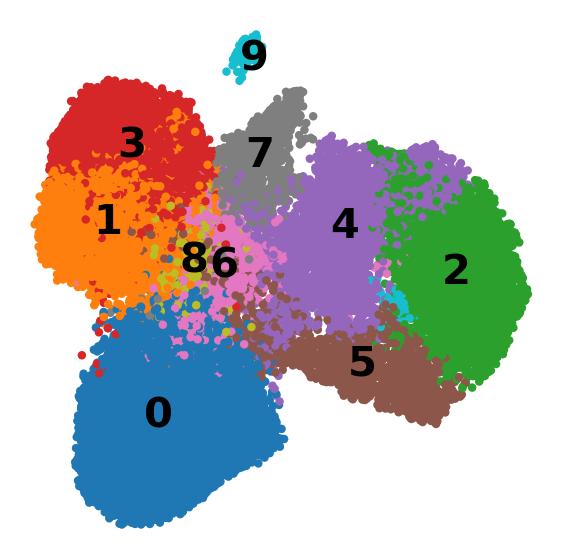

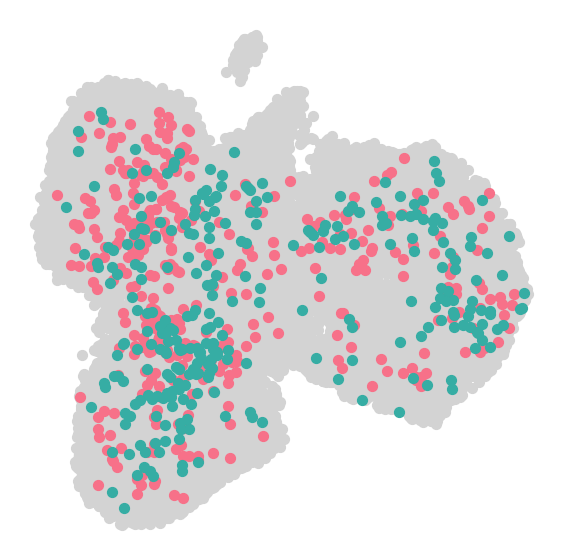

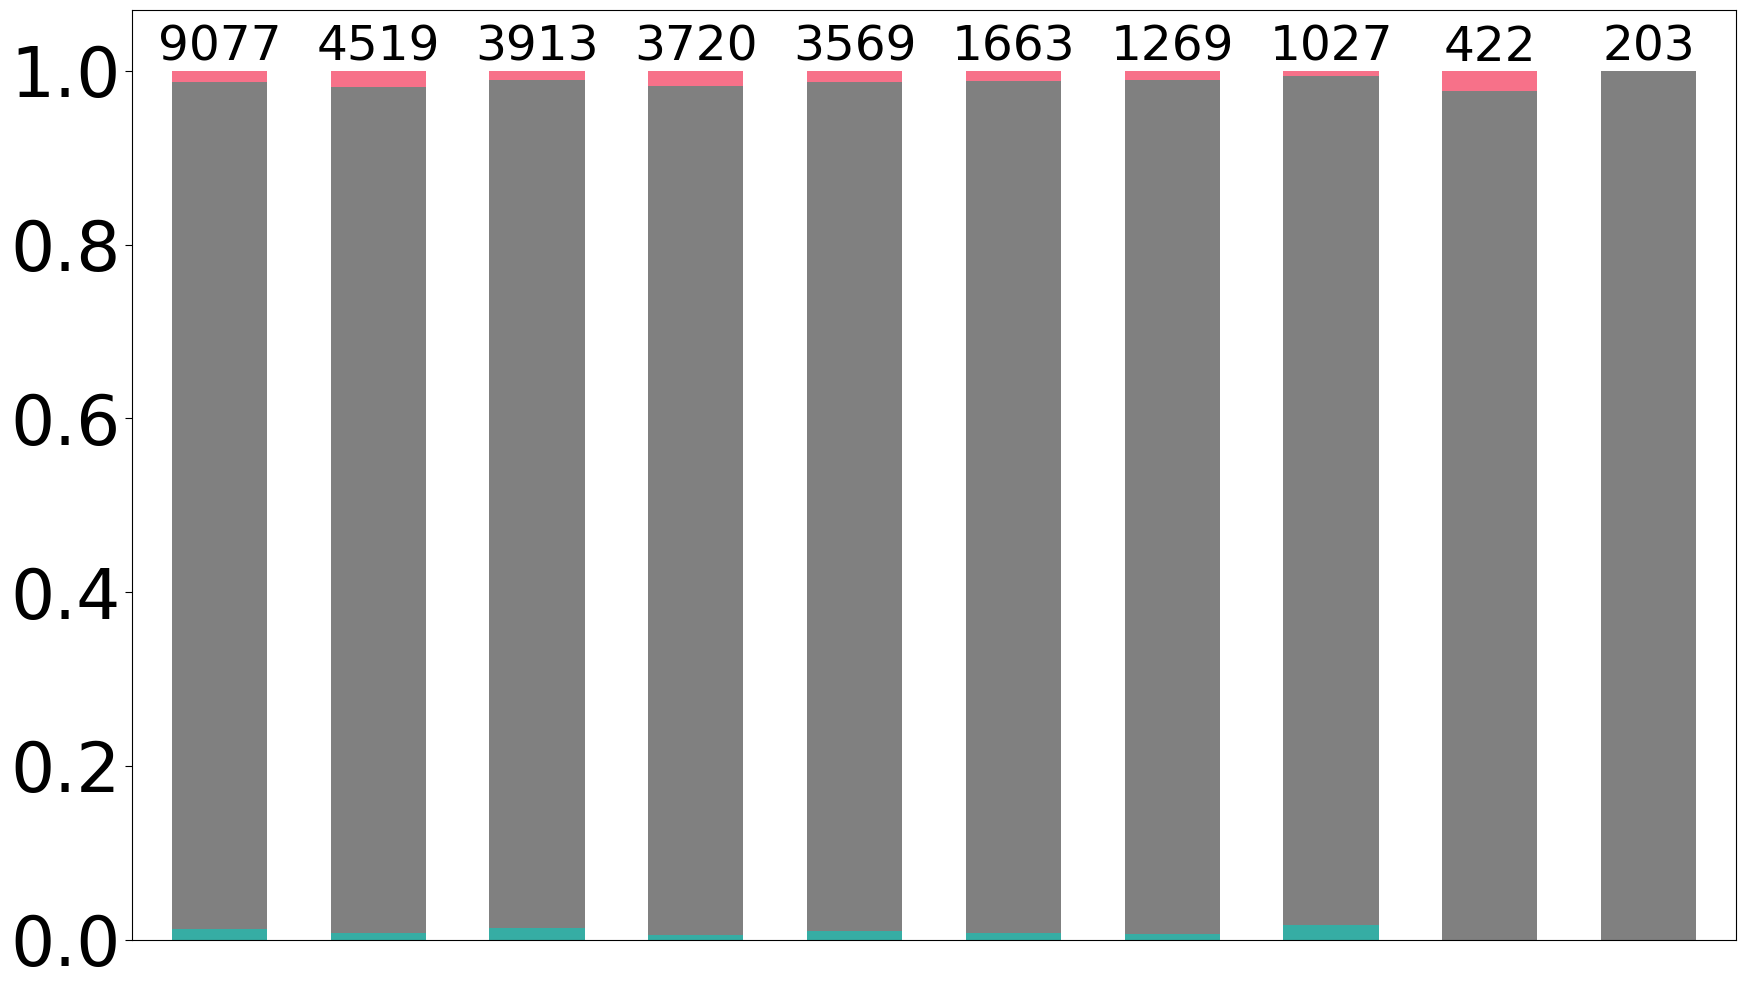

In [79]:
#this is for PCs=20
adata_OG = default_pipeline(adata2, 4000, 20, 0.5)

############################ num_pcs: 40; num_hvg: 4000 ############################


/Genomics/pritykinlab/dillon/software/miniconda/envs/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


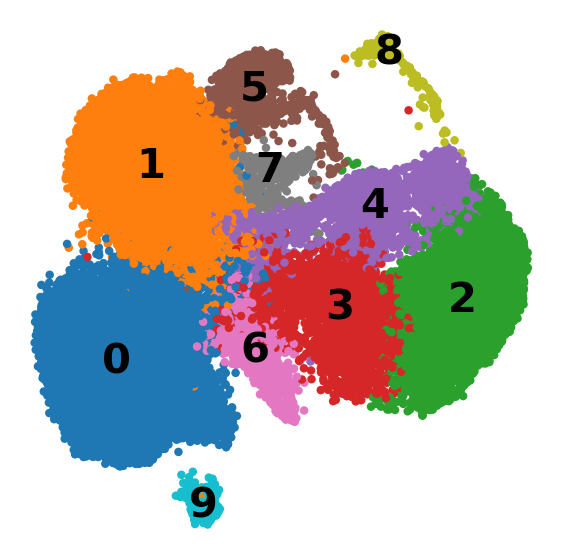

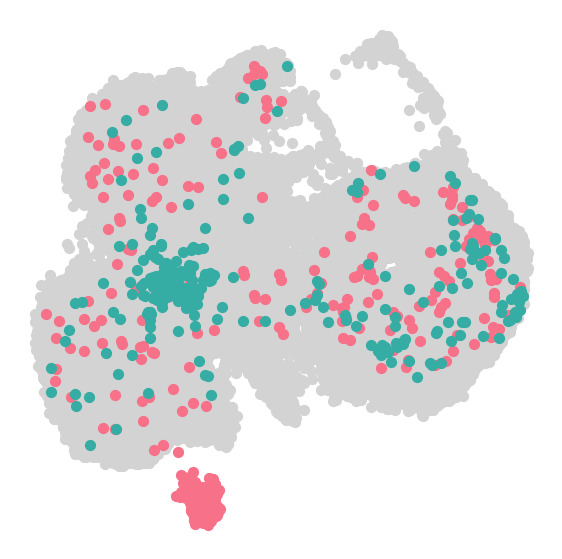

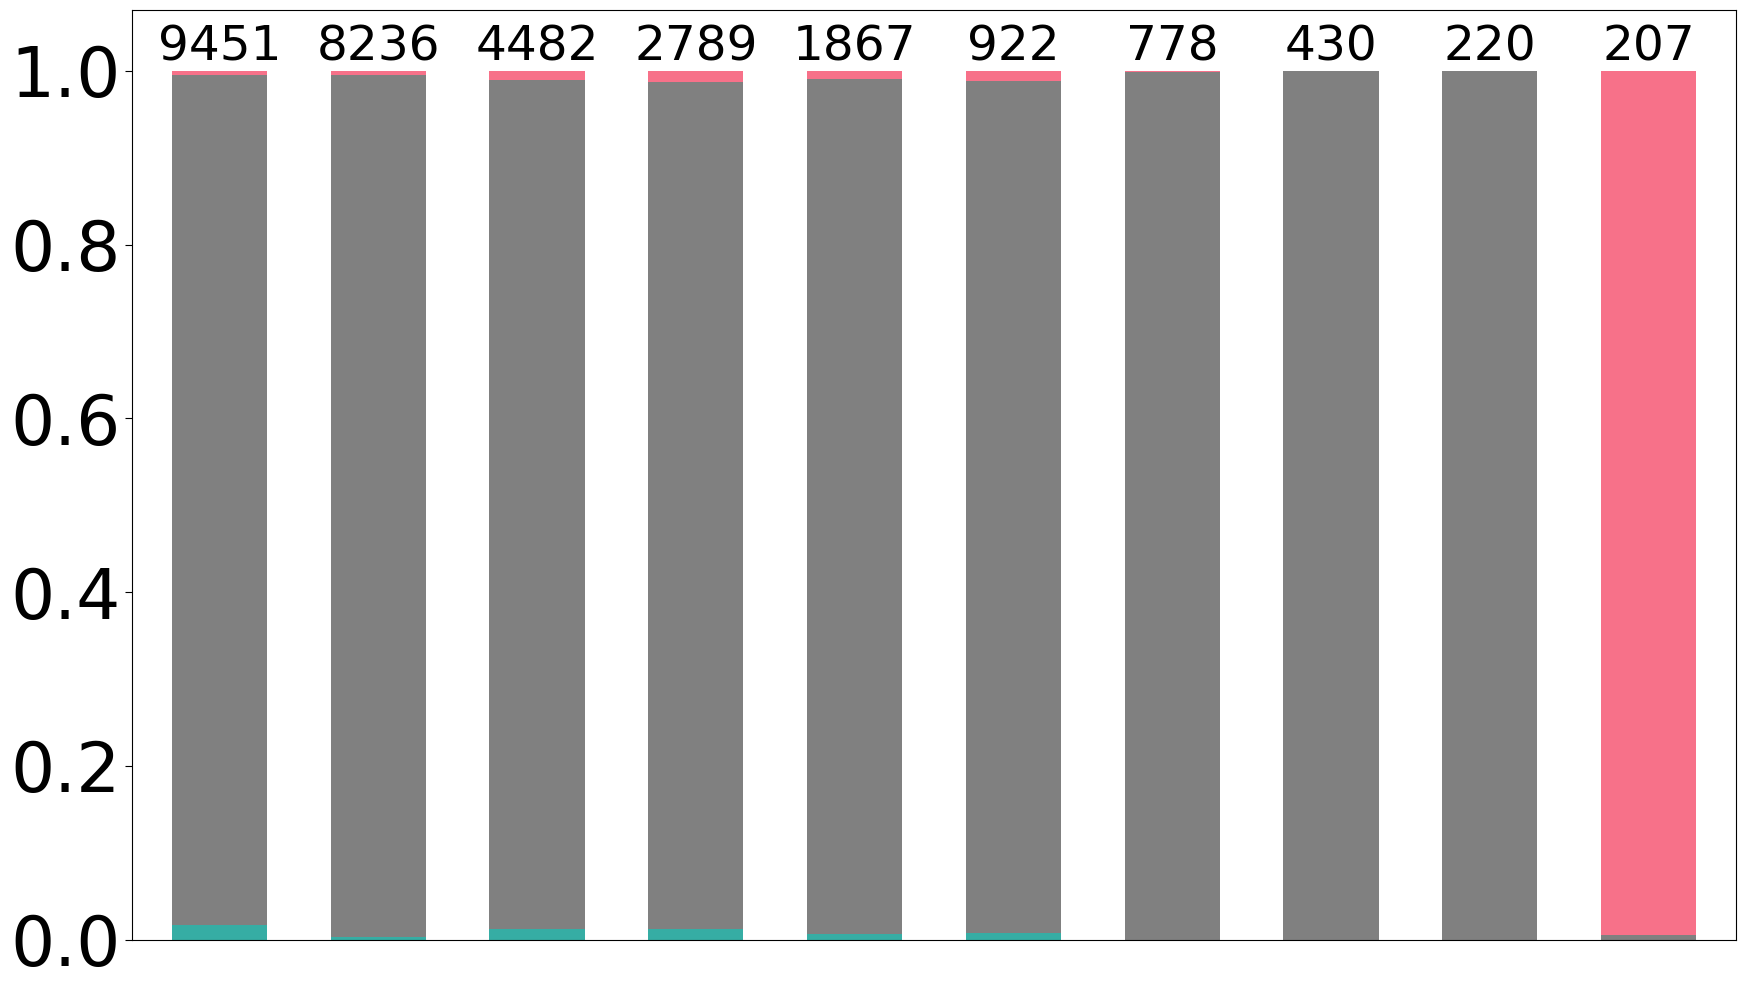

In [80]:
#this is for PCs=40
adata_OG = default_pipeline(adata2, 4000, 40, 0.35)

############################ num_pcs: 100; num_hvg: 4000 ############################


/Genomics/pritykinlab/dillon/software/miniconda/envs/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


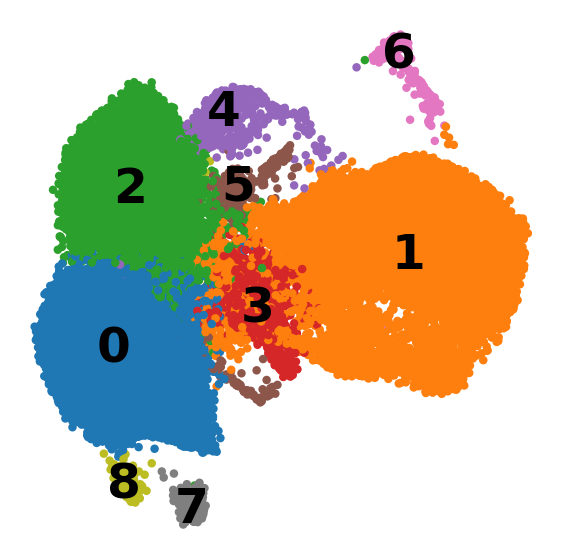

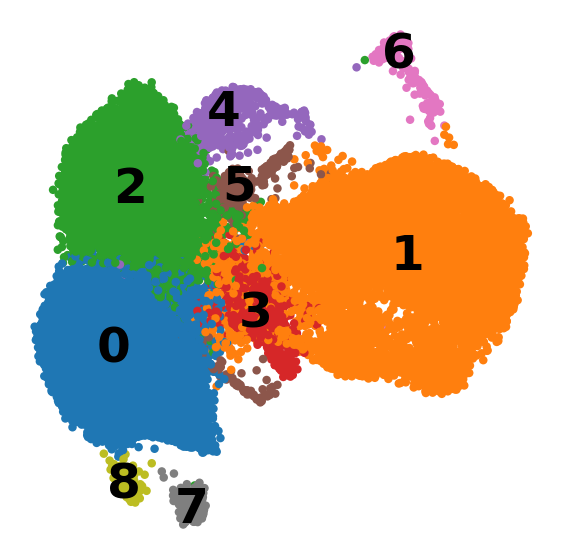

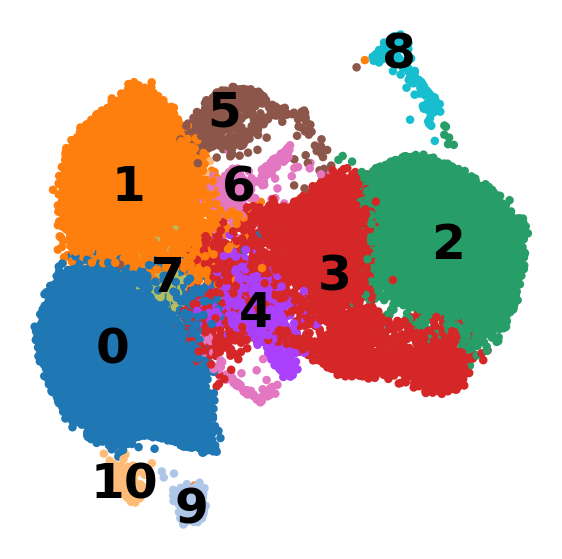

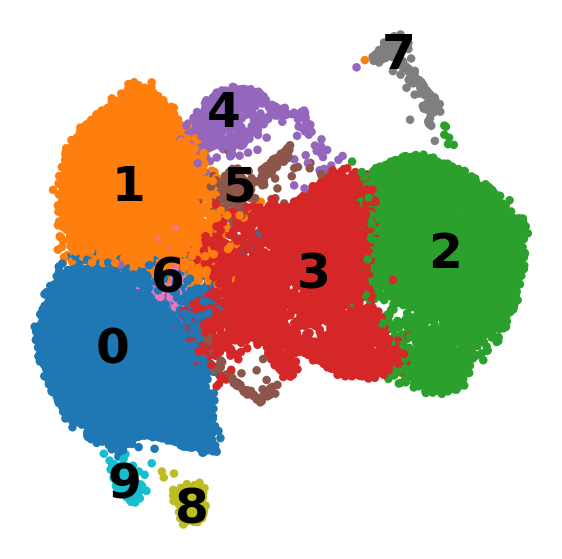

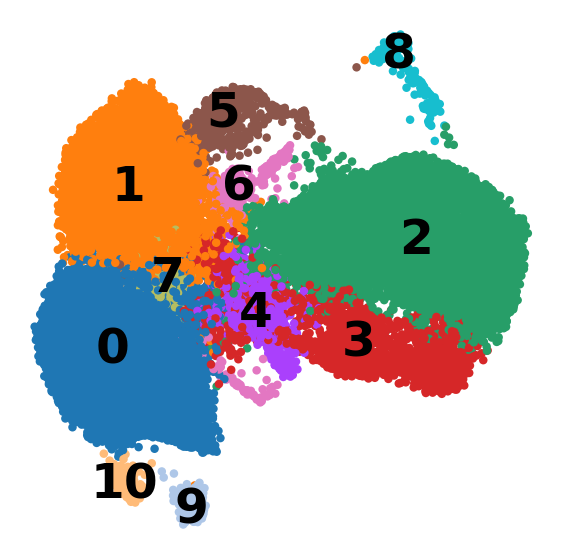

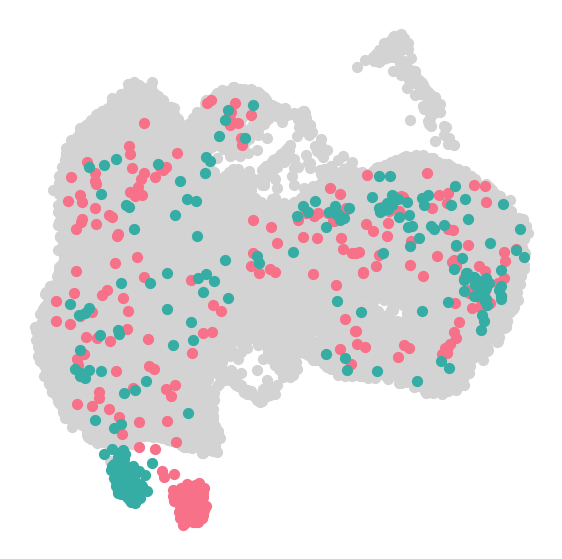

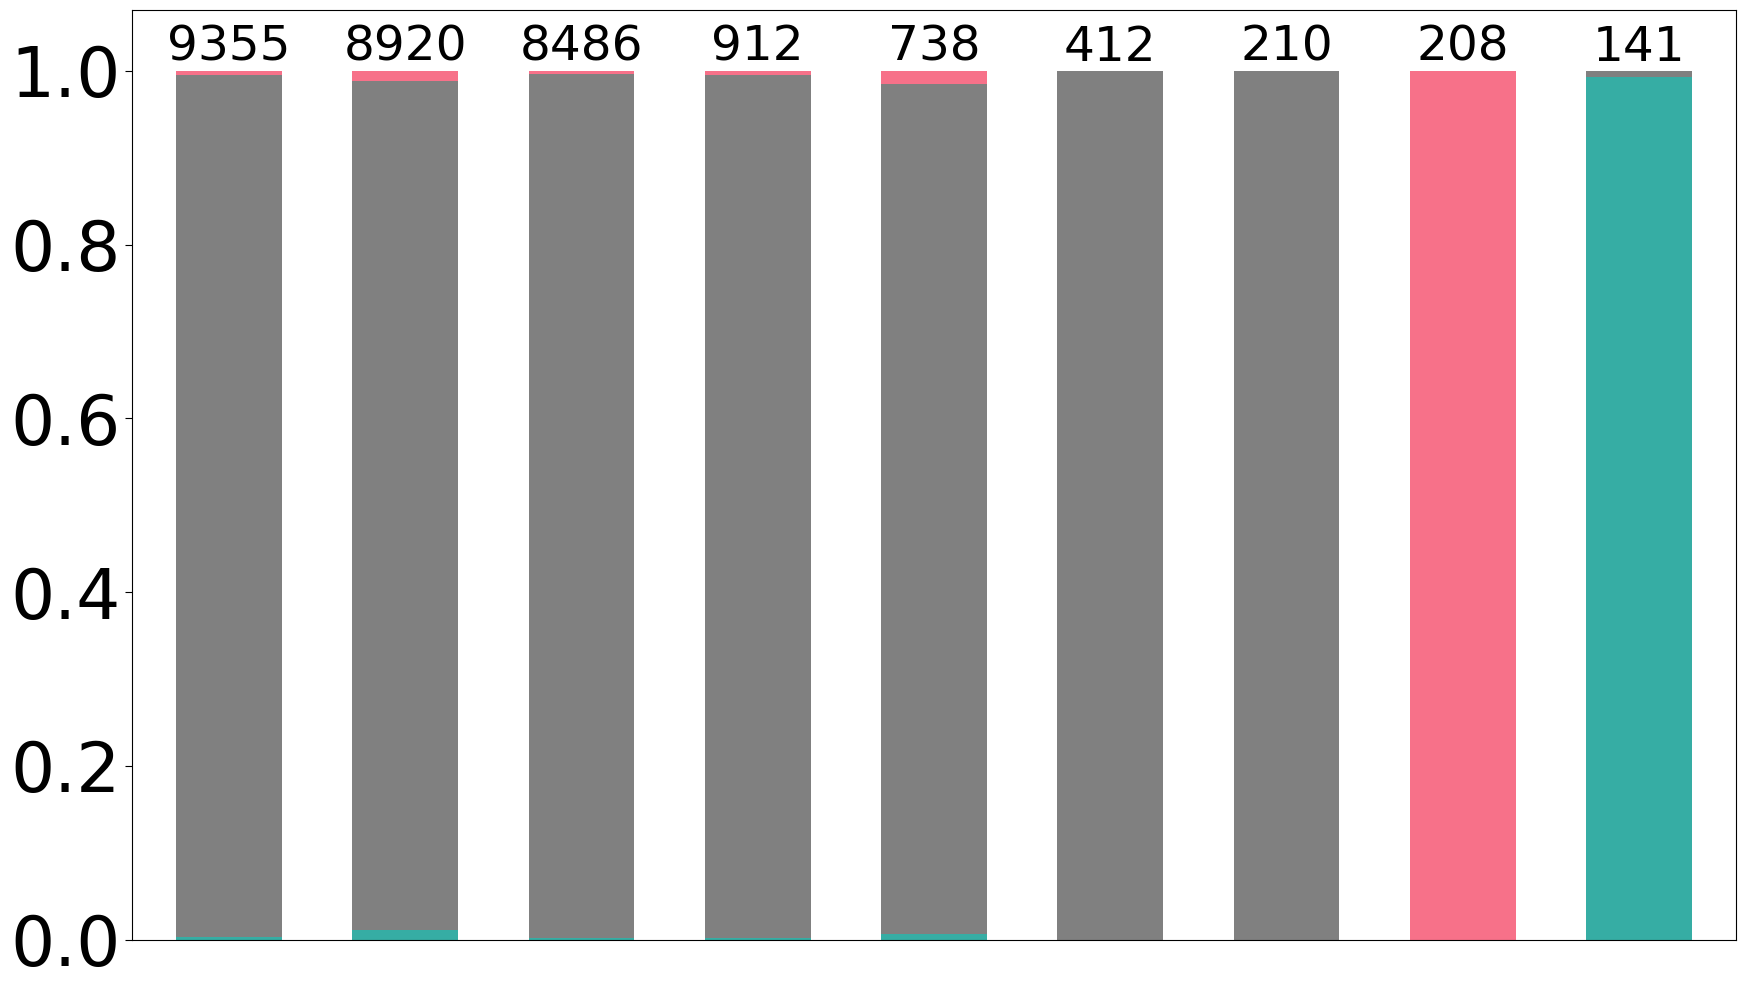

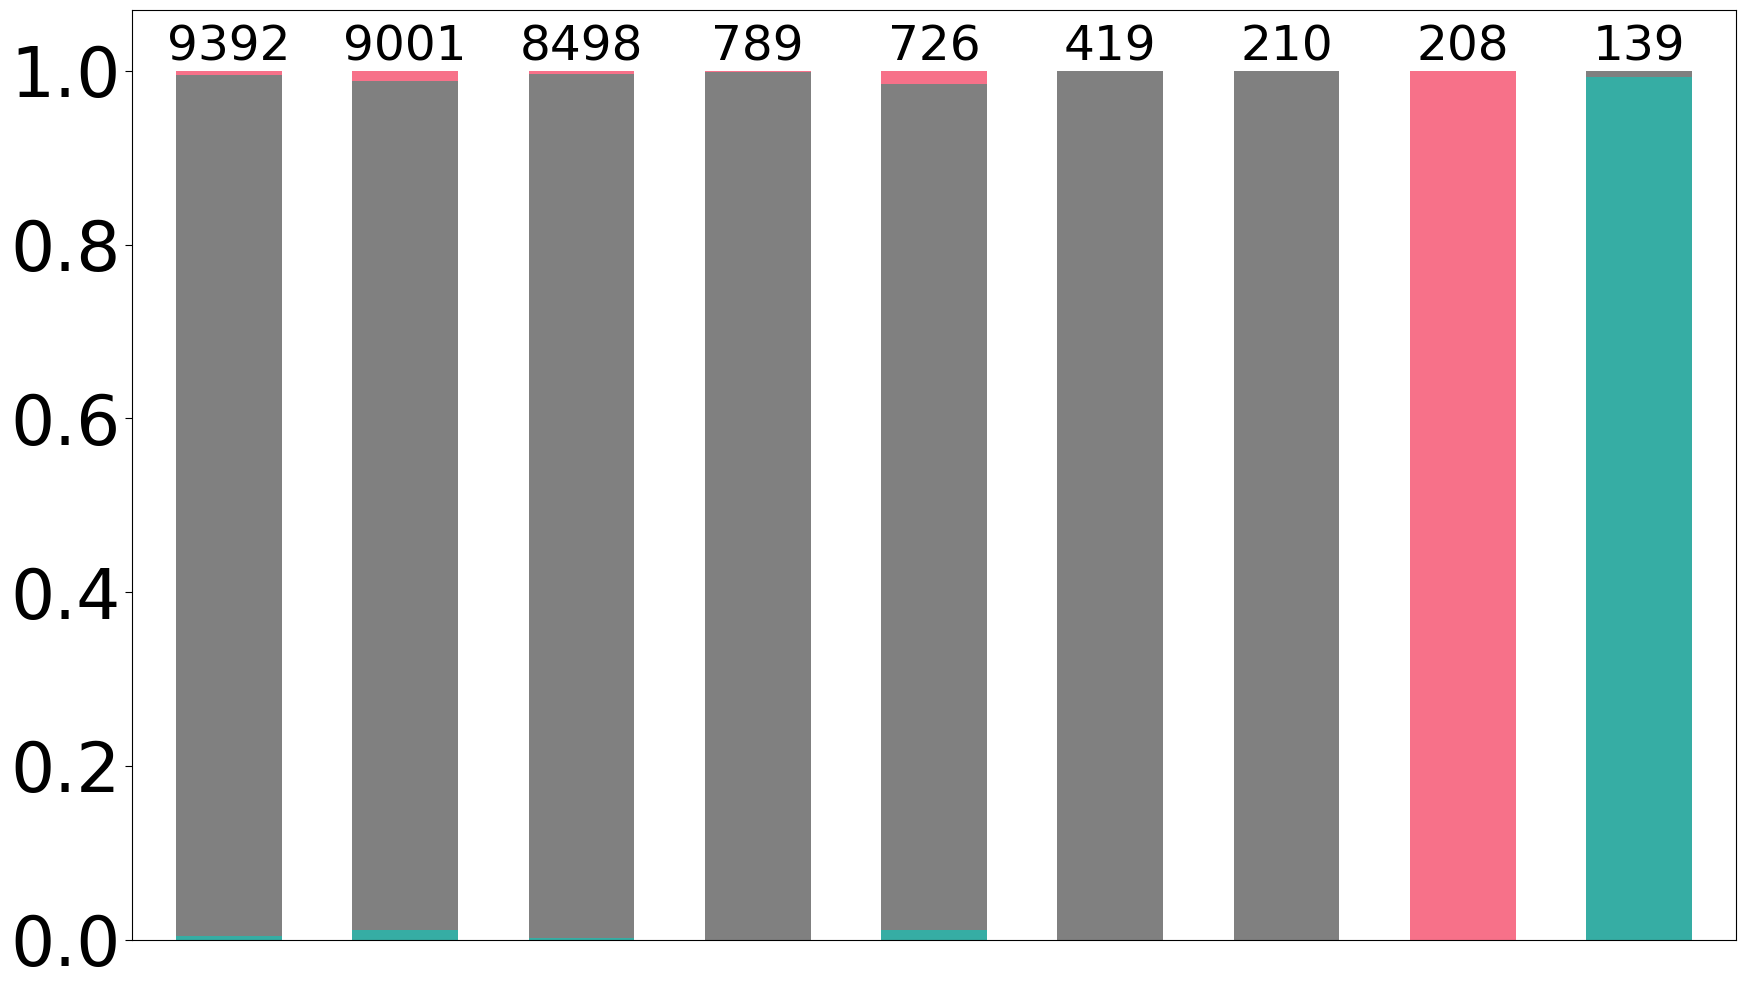

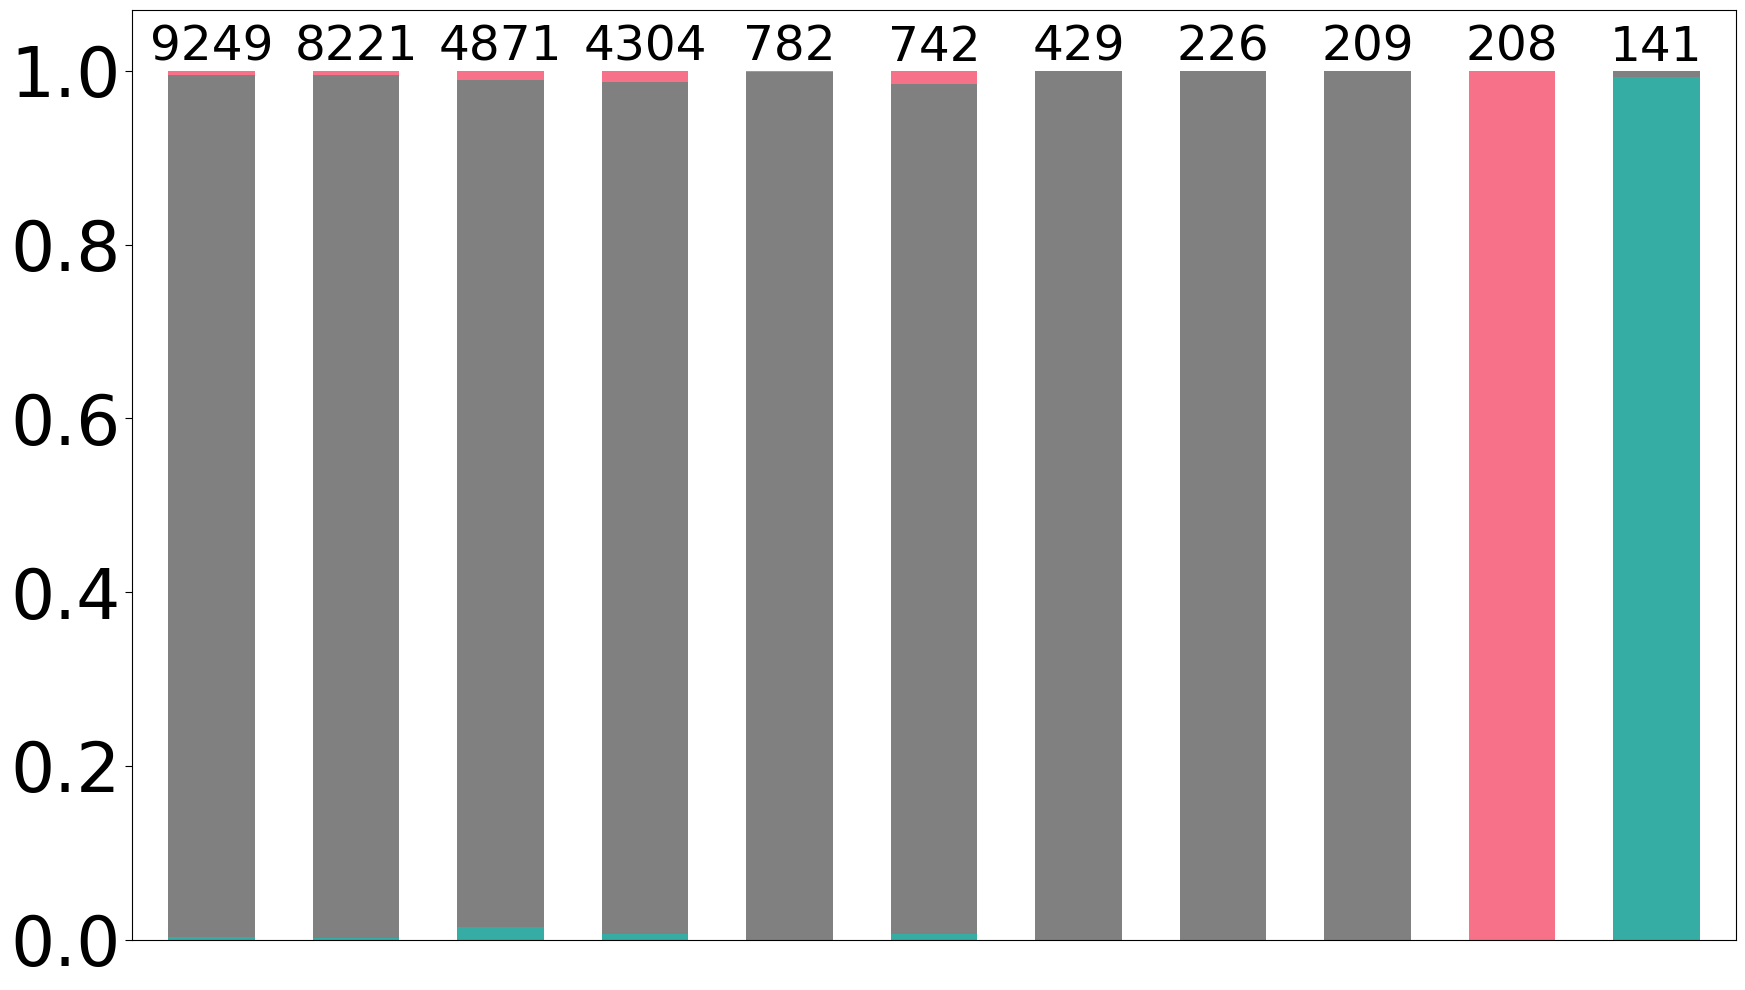

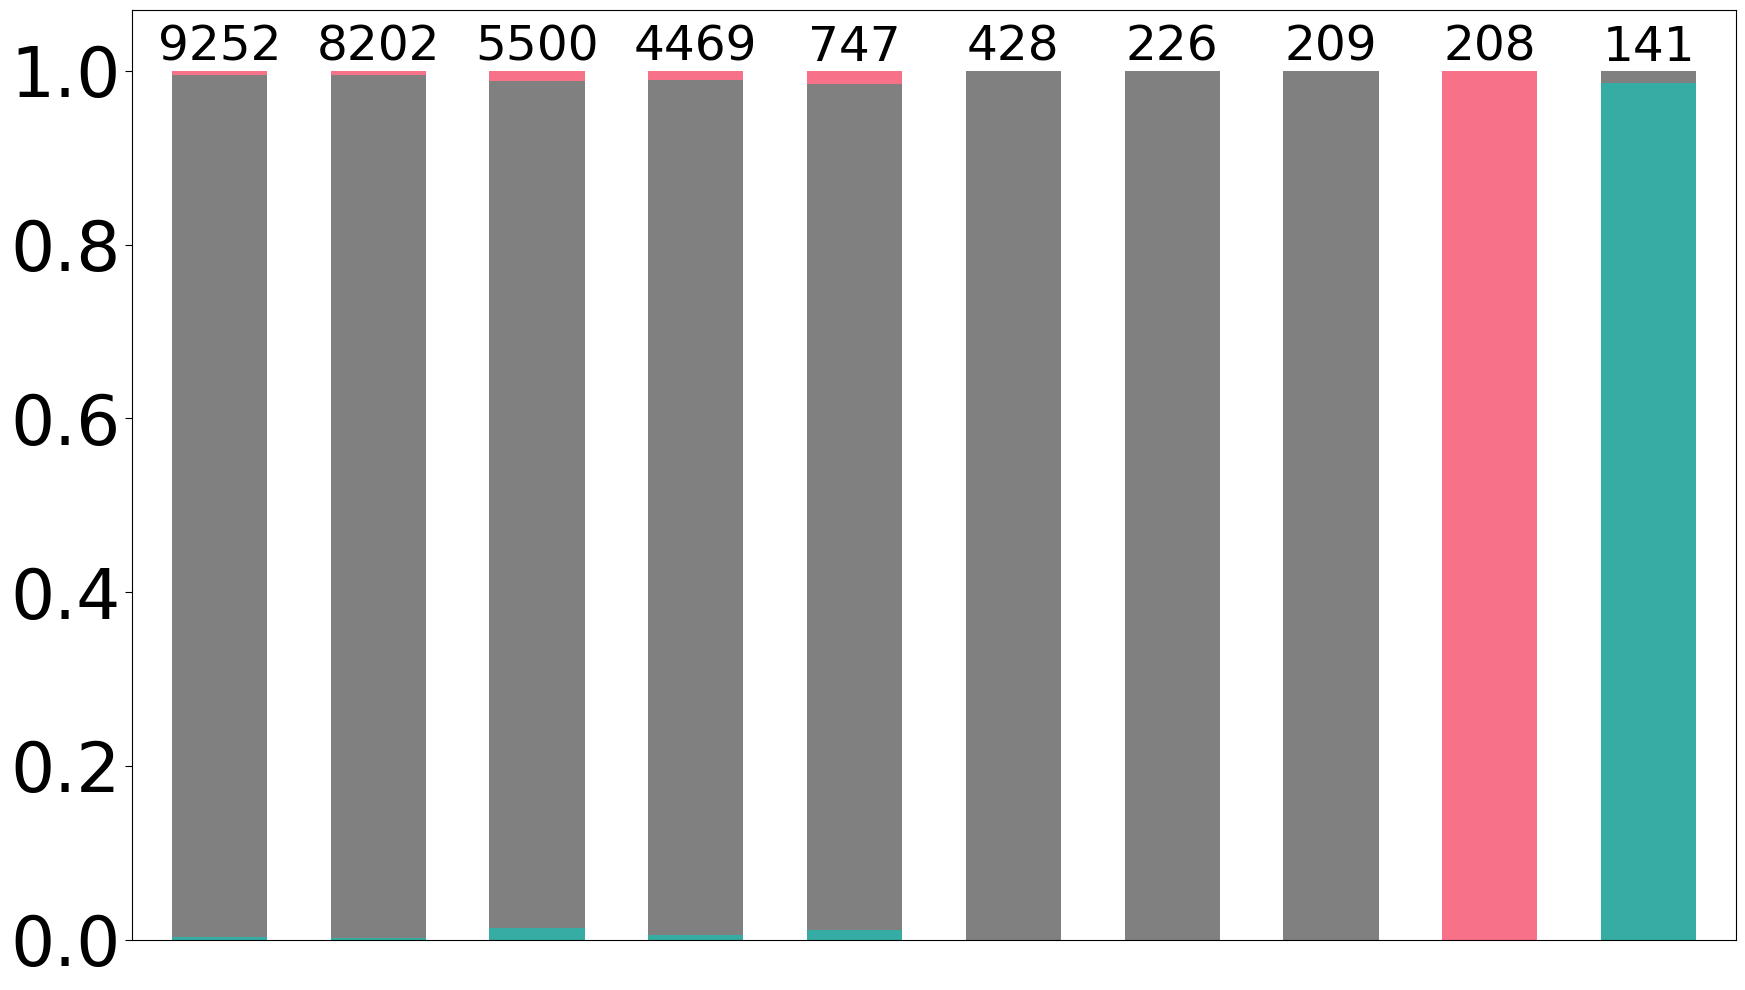

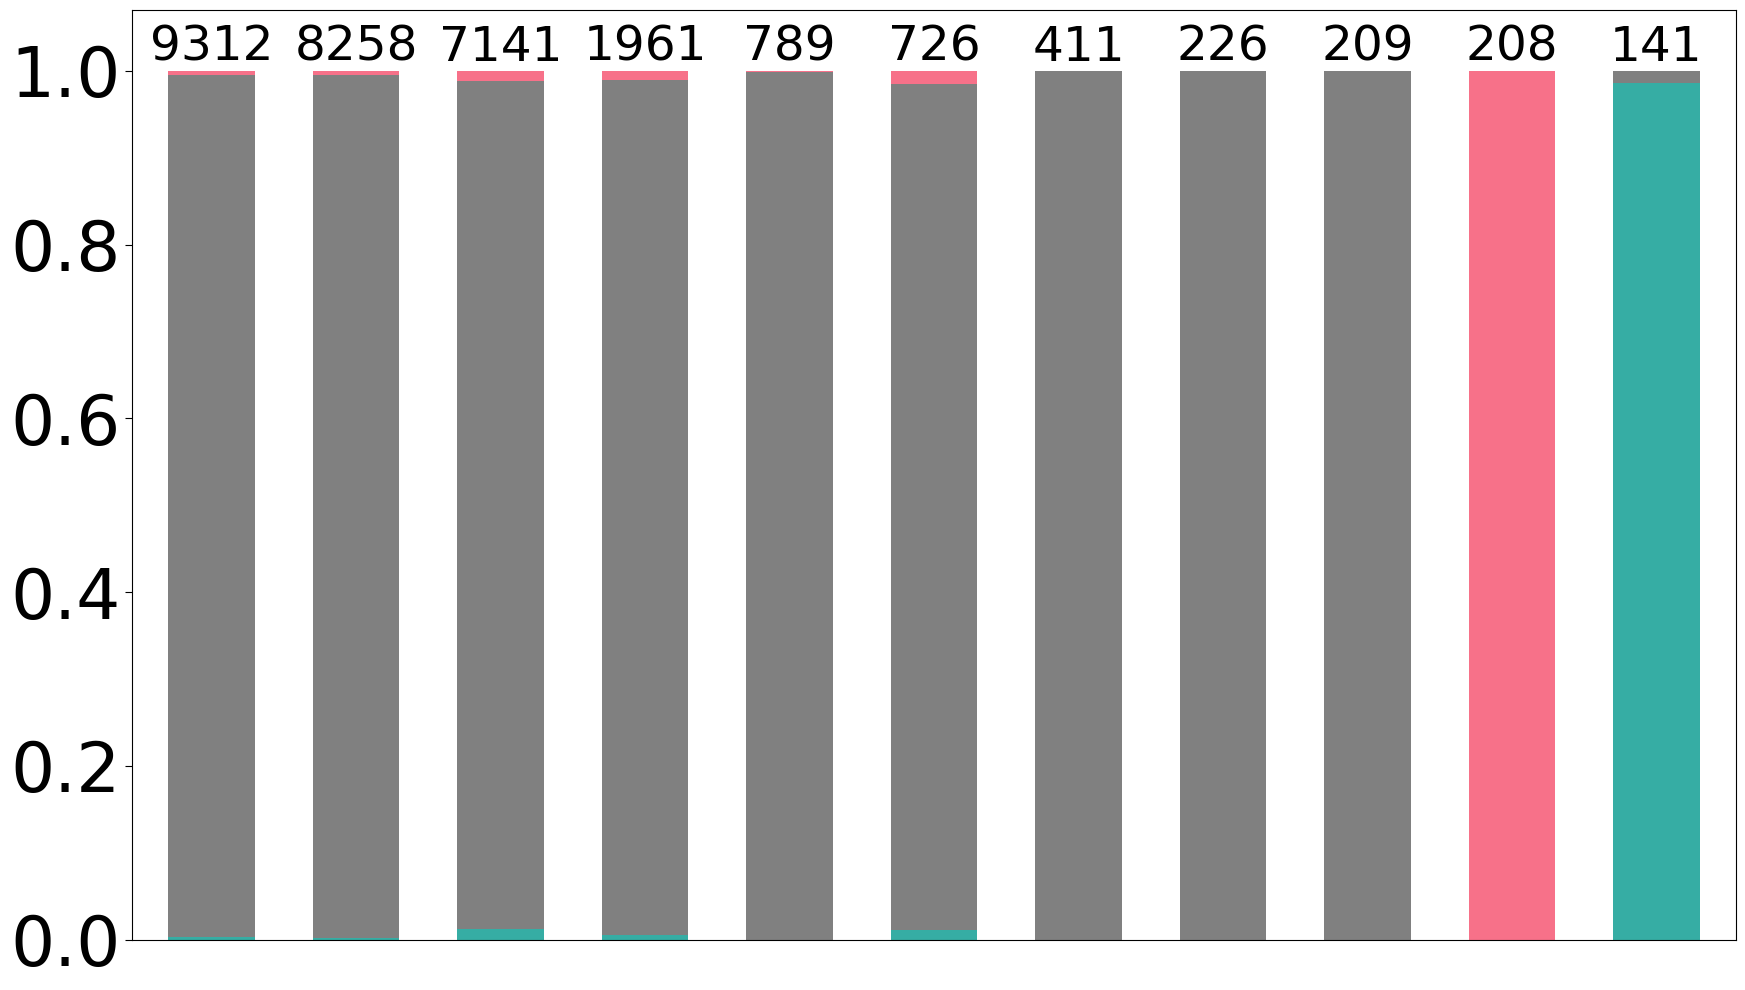

In [16]:
#this is for PCs=100
adata_100 = default_pipeline(adata2, 4000, 100, [0.28, 0.285, 0.29, 0.295, 0.3])

############################ num_pcs: 1000; num_hvg: 4000 ############################


/Genomics/pritykinlab/dillon/software/miniconda/envs/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


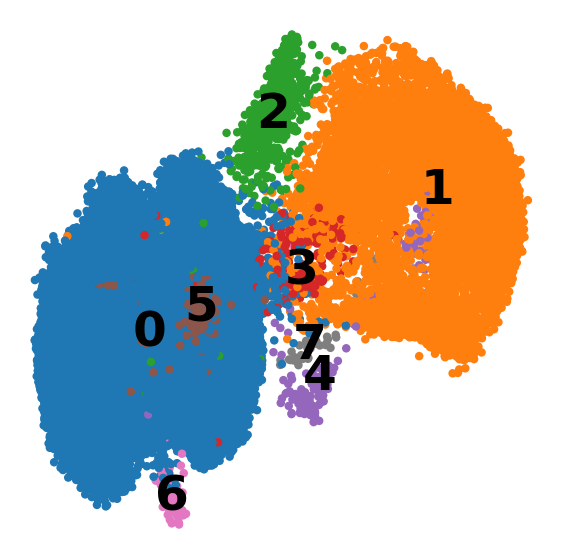

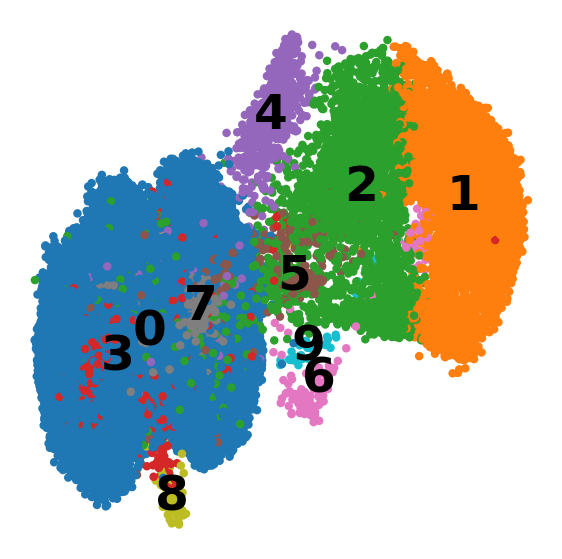

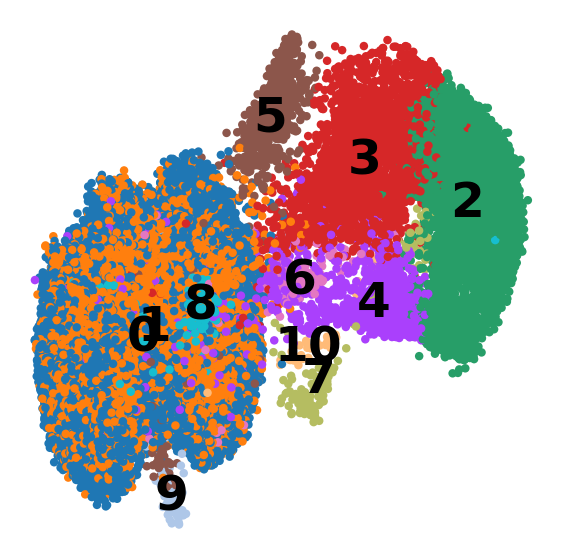

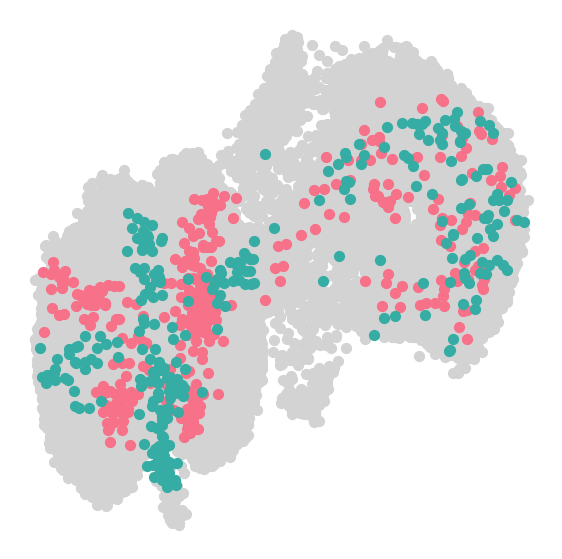

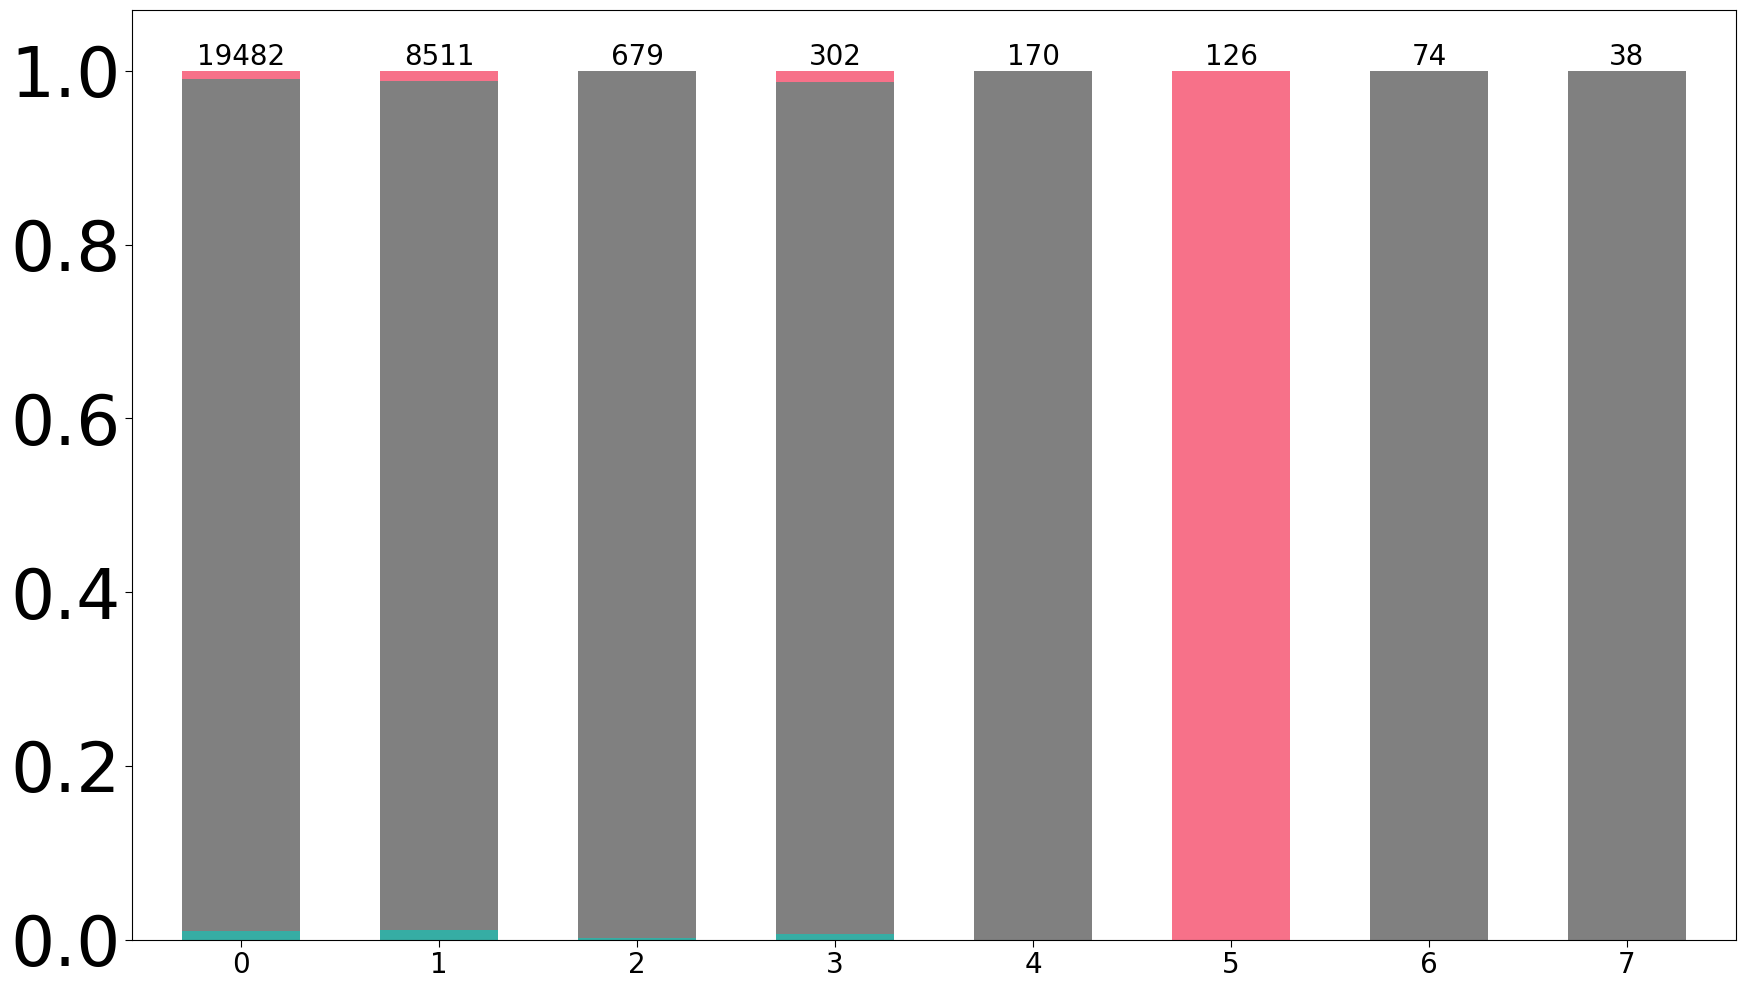

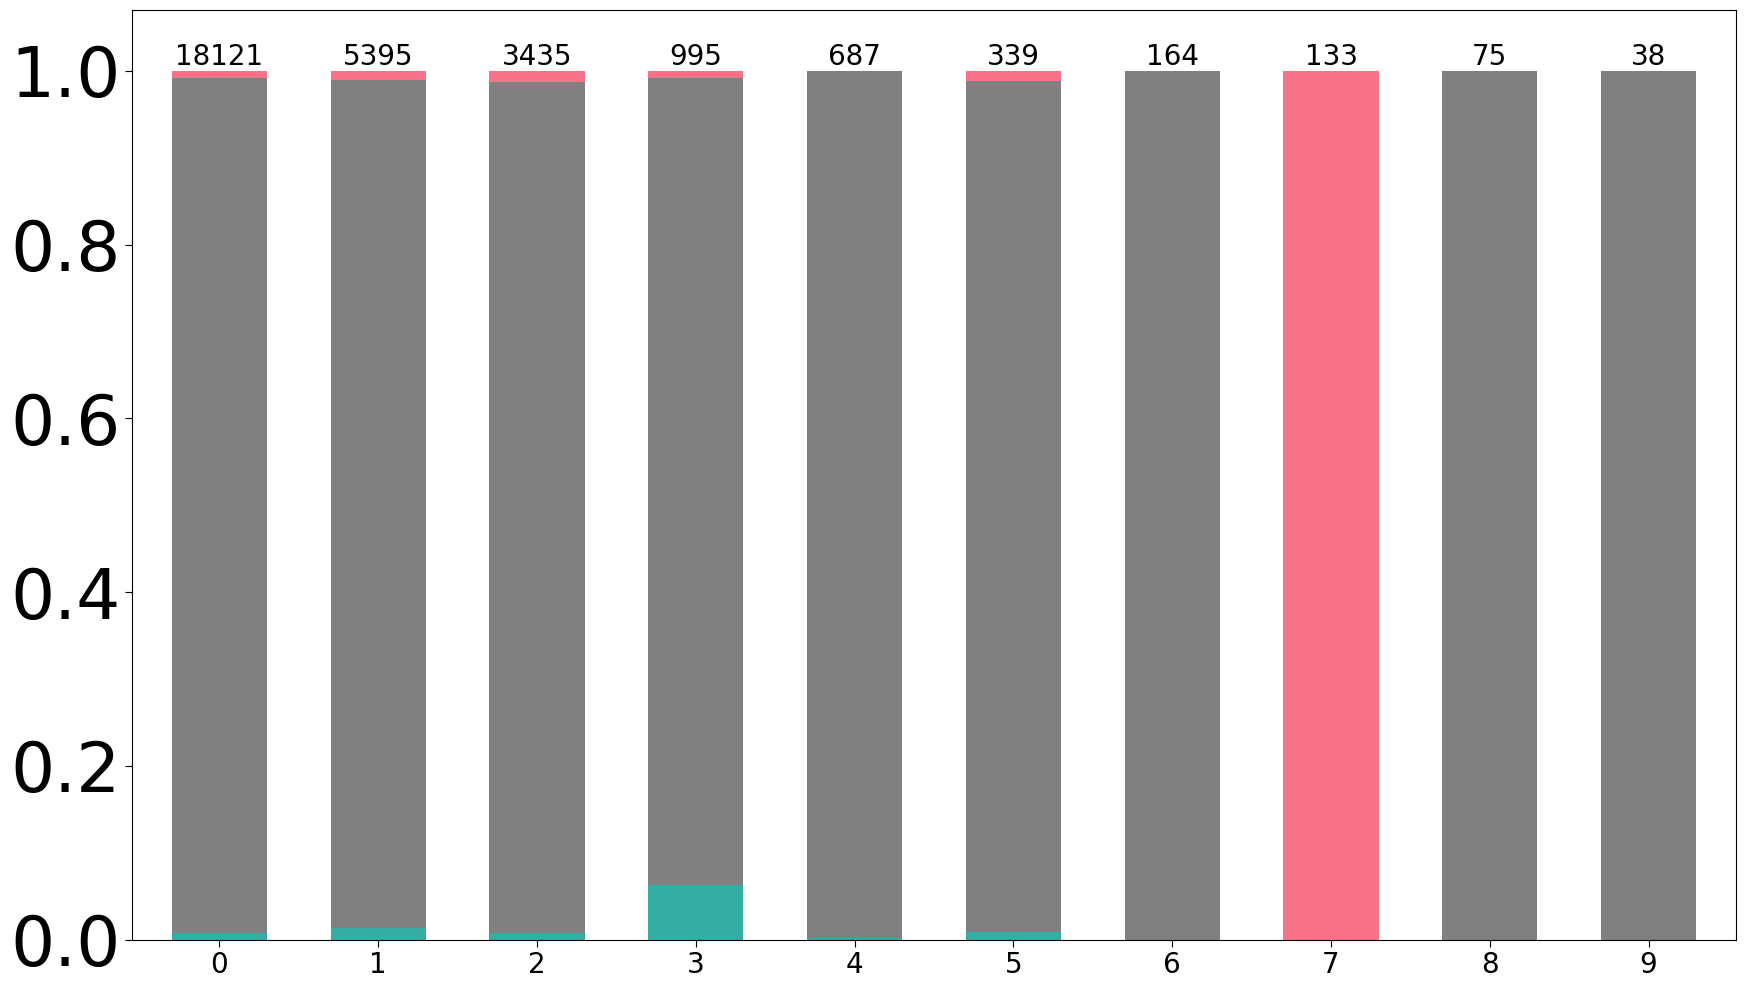

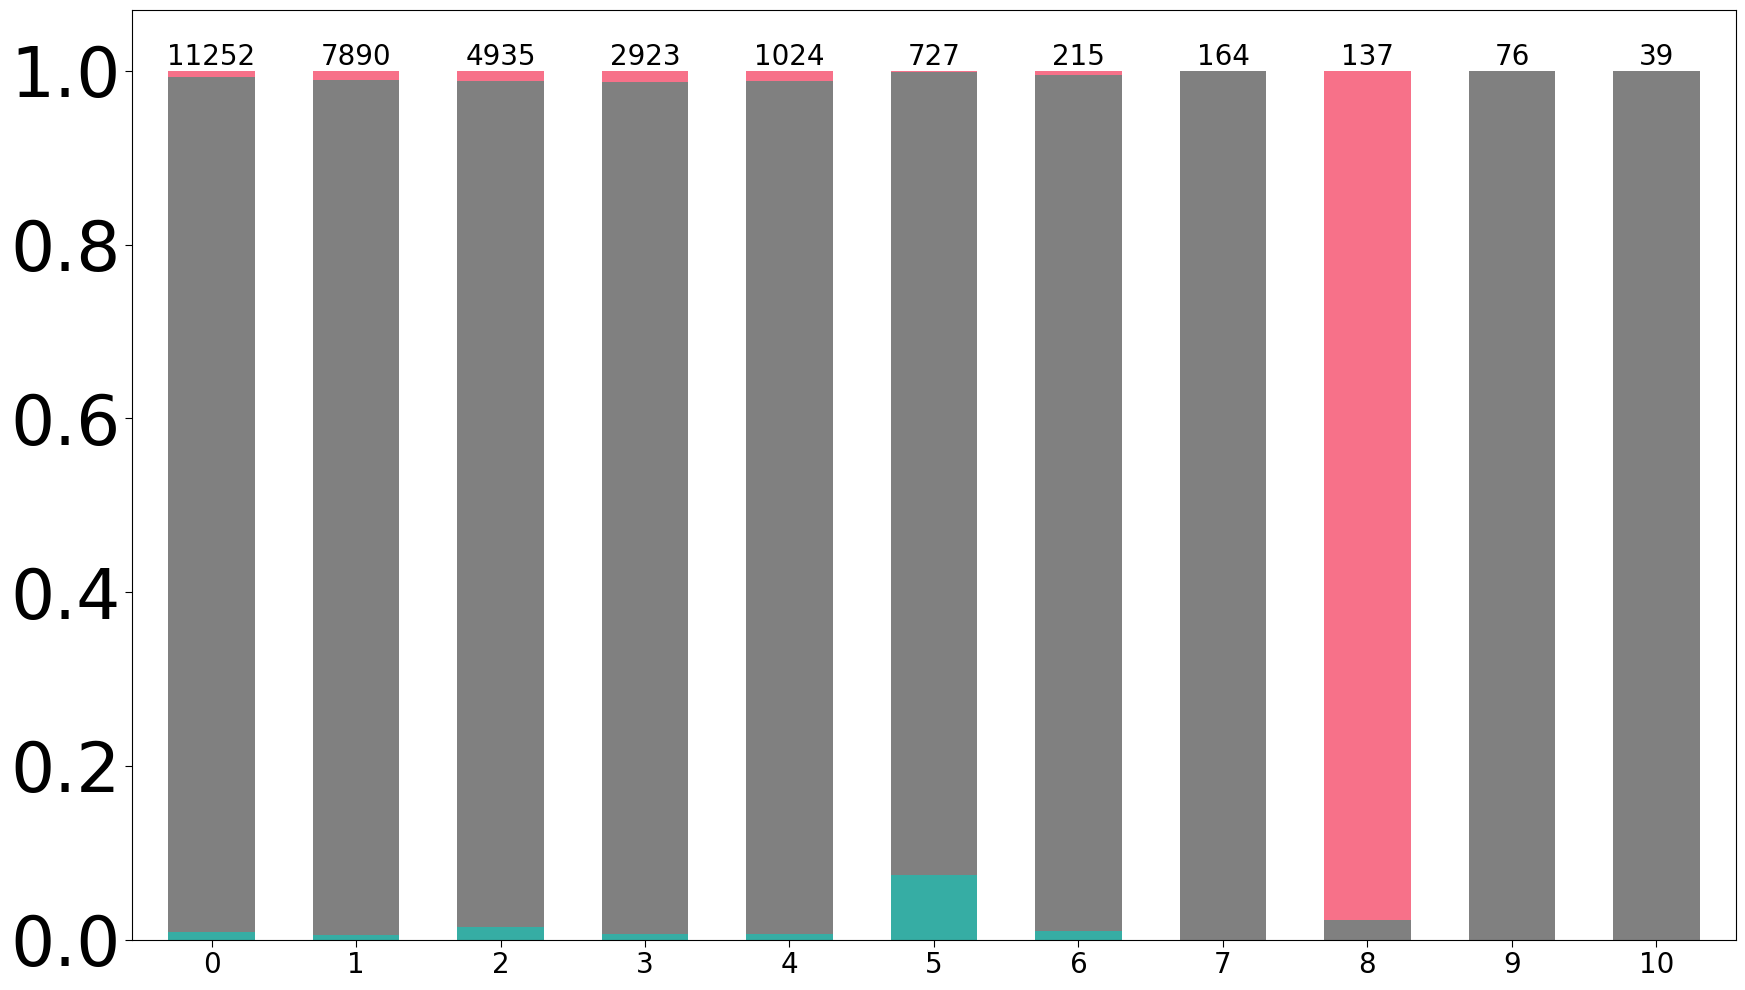

In [10]:
#this is for PCs=1000
adata_1000 = default_pipeline(adata2, 4000, 1000, [0.6, 0.7, 0.8])

# Panel d

In [5]:
def default_pipeline(your_adata, num_hvg, num_pcs):
    adata = your_adata.copy()
    sc.pp.normalize_total(adata)
    adata.layers['raw_norm'] = adata.X.copy()
    sc.pp.log1p(adata)
    if num_hvg is not None:
        sc.pp.highly_variable_genes(adata, n_top_genes=num_hvg, flavor='seurat')
        adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=num_pcs)

    return adata

adata_20 = default_pipeline(adata2, 4000, 20)
adata_40 = default_pipeline(adata2, 4000, 40)
adata_100 = default_pipeline(adata2, 4000, 100)
# adata_1000 = default_pipeline(adata2, 4000, 1000)

/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Genomics/argo/users/yq7946/.conda/envs/myenv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


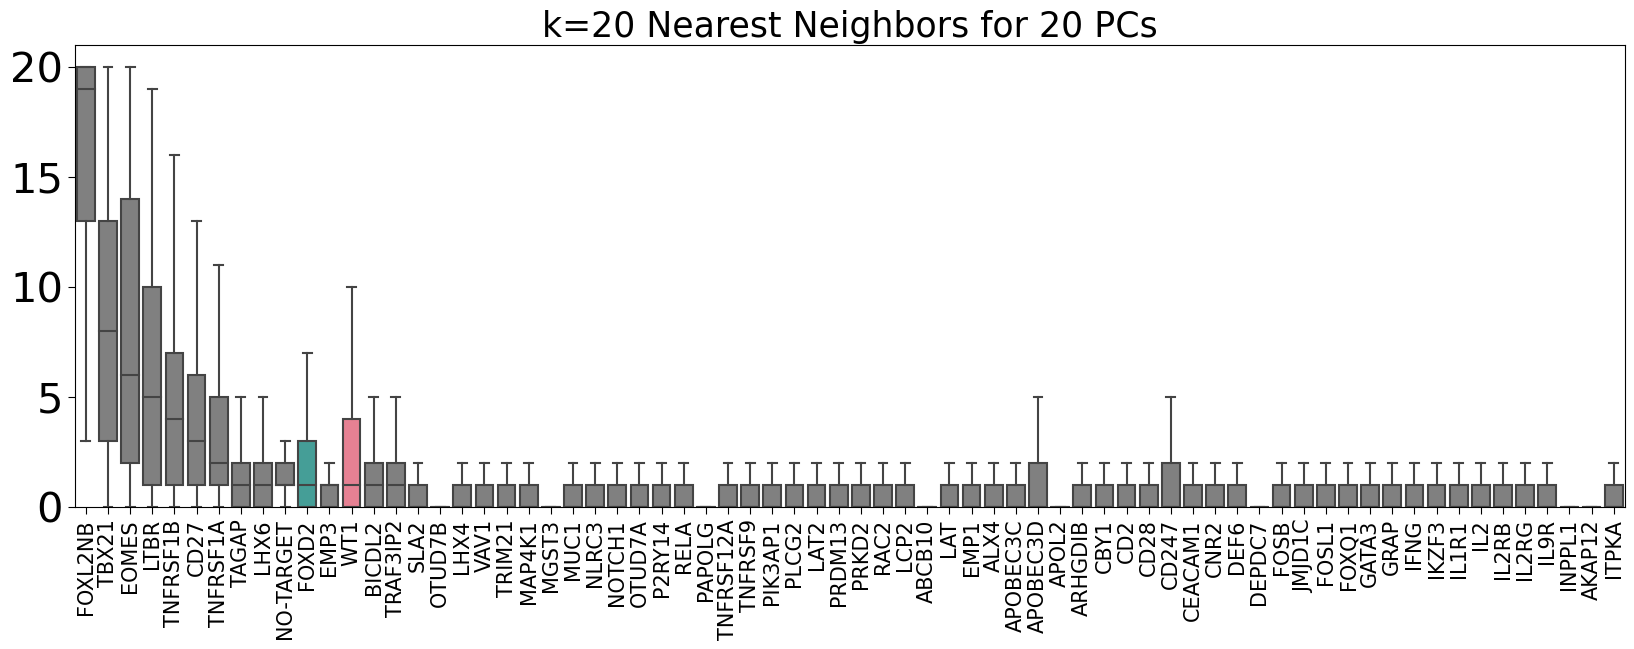

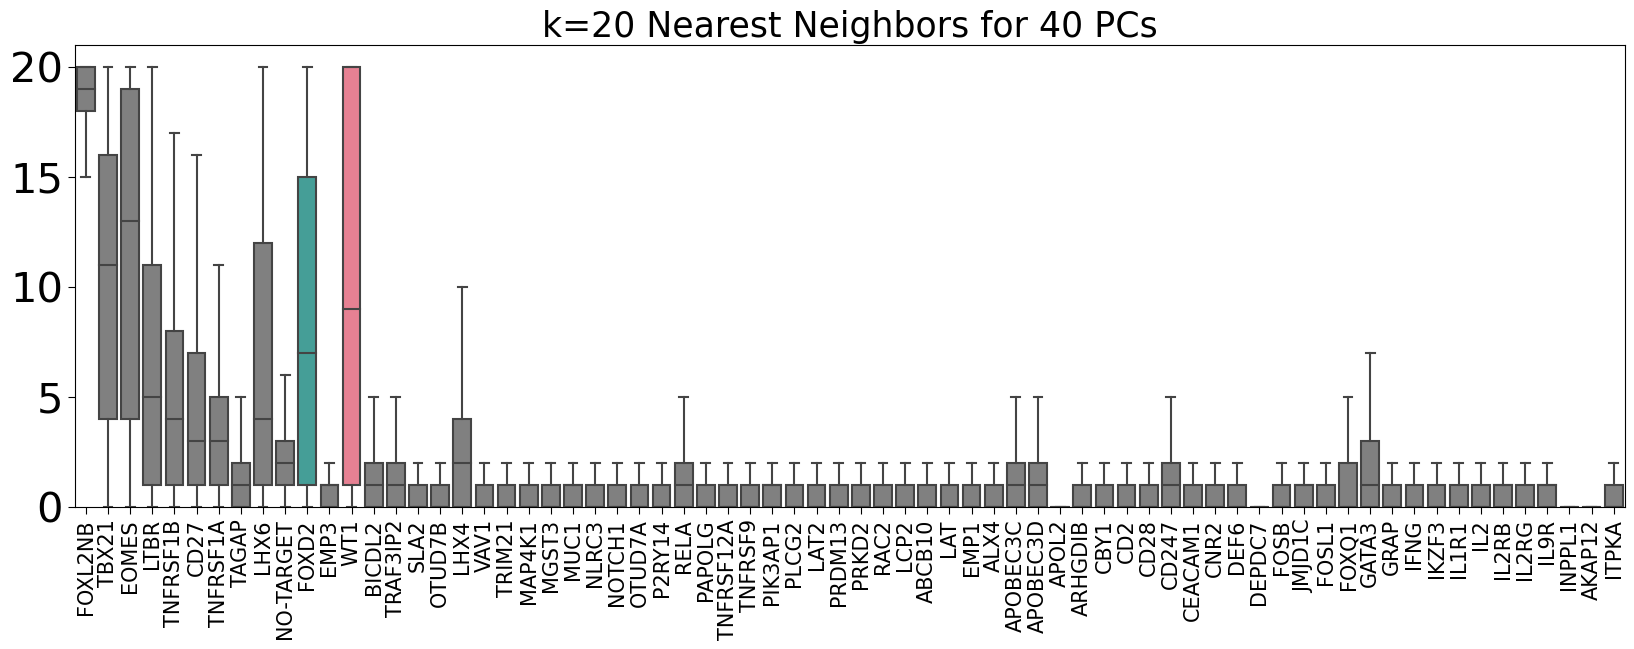

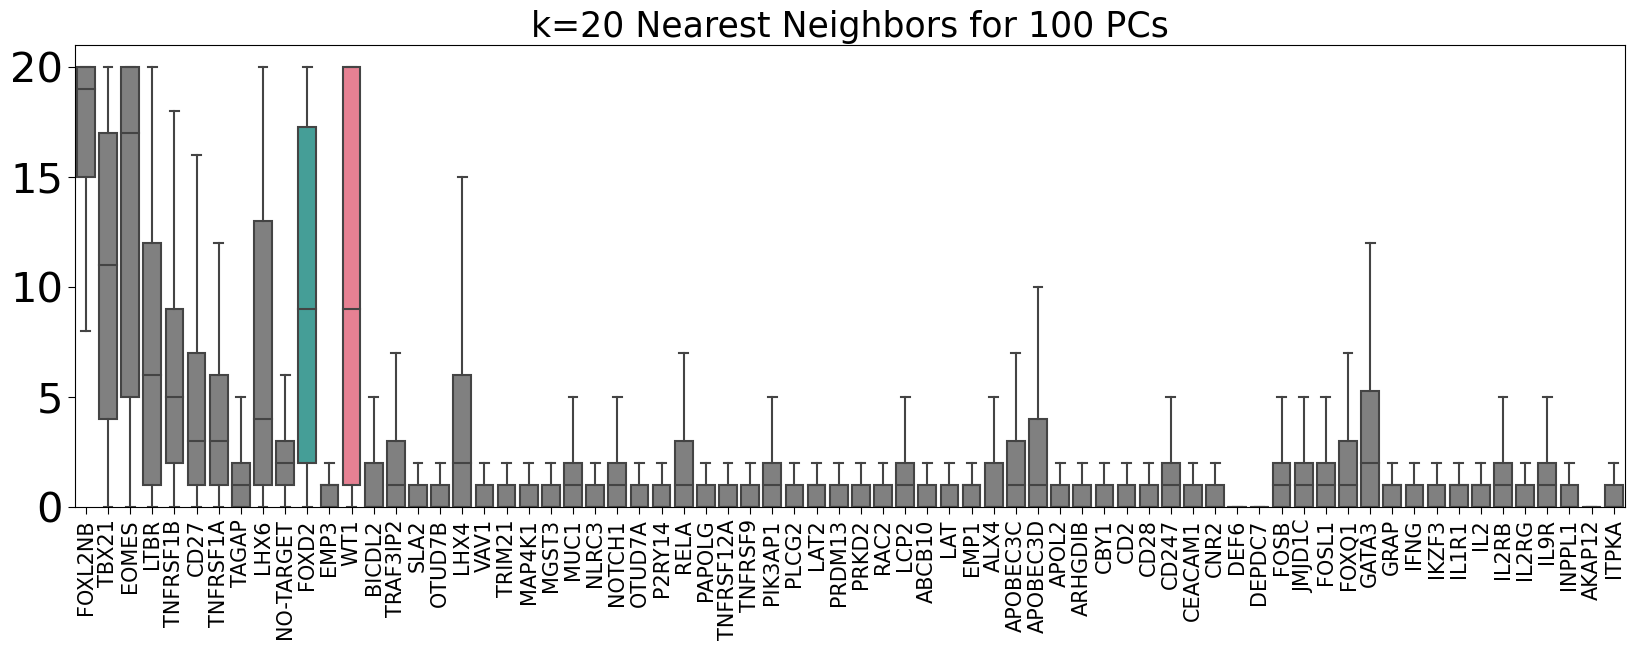

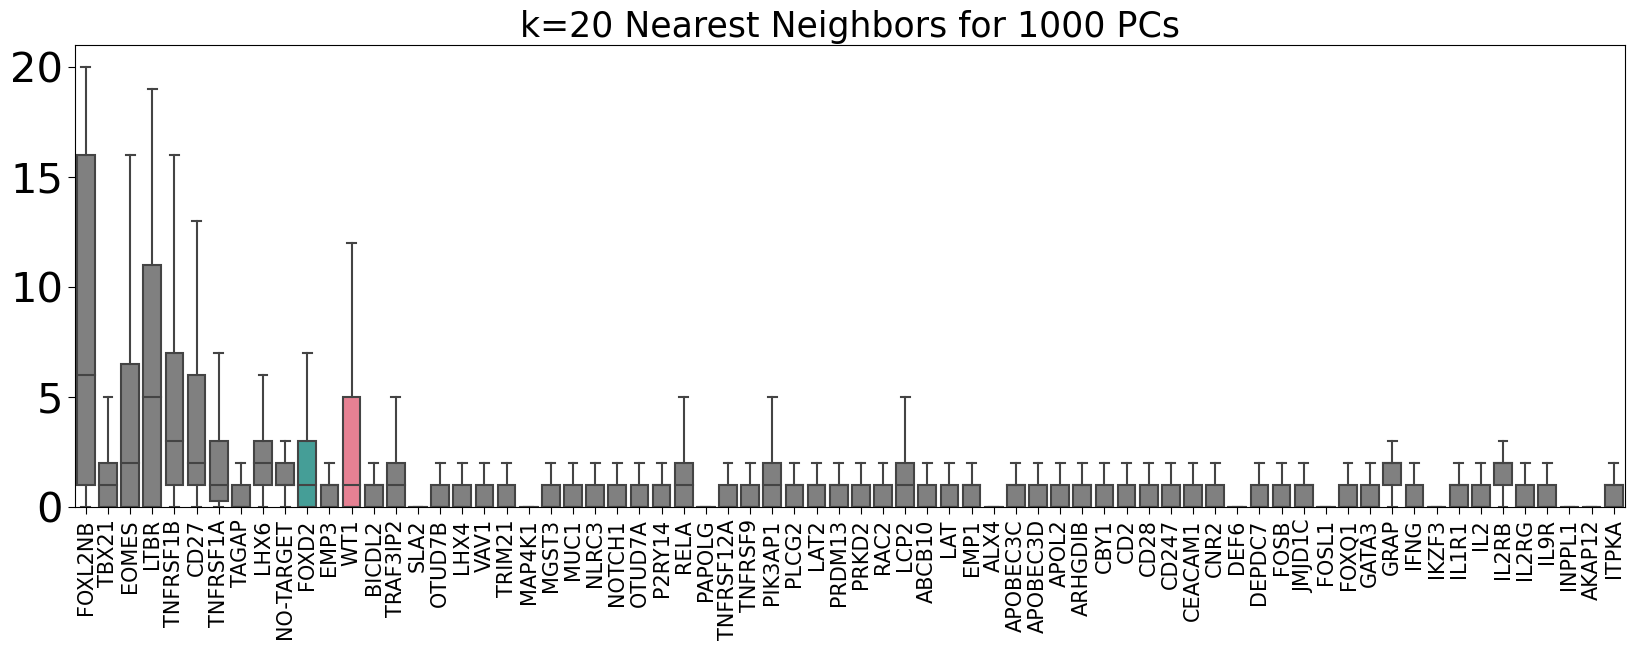

In [29]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Function to create the k-nearest neighbor graph and add the number of neighbors with the same perturbation
def add_knn_with_same_perturbation(adata, k=20):
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(adata.obsm['X_pca'])
    distances, indices = knn.kneighbors(adata.obsm['X_pca'])
    adata.obs['knn_with_same_perturbation'] = [
        sum(adata.obs['gene'][indices[i][1:]] == adata.obs['gene'][i])
        for i in range(adata.n_obs)
    ]

add_knn_with_same_perturbation(adata_20)
add_knn_with_same_perturbation(adata_40)
add_knn_with_same_perturbation(adata_100)
add_knn_with_same_perturbation(adata_1000)

# alternative plots
# Combine the results into a single DataFrame
dfs = []
for adata, pcs in zip([adata_20, adata_40, adata_100, adata_1000], [20, 40, 100, 1000]):
    df = adata.obs[['gene', 'knn_with_same_perturbation']].copy()
    df['num_pcs'] = pcs
    dfs.append(df)

combined_df = pd.concat(dfs)

# Define colors
colors_dict = {
    'WT1': sns.color_palette("husl", 2)[0],
    'FOXD2': sns.color_palette("husl", 2)[1]
}

# Assign 'grey' color to all other perturbations
for perturbation in combined_df['gene'].unique():
    if perturbation not in colors_dict:
        colors_dict[perturbation] = 'grey'

df = combined_df[combined_df['num_pcs'] == 20]
median_per_perturbation = df.groupby('gene')['knn_with_same_perturbation'].median().sort_values(ascending=False)
# Plot per adata PC level
for pcs in [20, 40, 100, 1000]:
    df = combined_df[combined_df['num_pcs'] == pcs]
    
    # Calculate the median of knn_with_same_perturbation per perturbation
    
    plt.figure(figsize=(20, 6))
    sns.boxplot(
        x='gene', 
        y='knn_with_same_perturbation', 
        data=df, 
        palette=colors_dict,
        order=median_per_perturbation.index,
        showfliers=False
    )
    plt.ylim(0, 21)
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(range(0, 21, 5), fontsize=30)
    plt.title(f'k=20 Nearest Neighbors for {pcs} PCs')
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('')
    plt.show()


In [27]:
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

def shuffle_perturbations(adata, k=20):
    shuffled_adata = adata.copy()
    shuffled_adata.obs['shuffled_gene'] = shuffle(shuffled_adata.obs['gene'].values)
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(shuffled_adata.obsm['X_pca'])
    distances, indices = knn.kneighbors(shuffled_adata.obsm['X_pca'])
    shuffled_knn_counts = [
        sum(shuffled_adata.obs['shuffled_gene'][indices[i][1:]] == shuffled_adata.obs['shuffled_gene'][i])
        for i in range(shuffled_adata.n_obs)
    ]
    shuffled_adata.obs['shuffled_knn_with_same_perturbation'] = shuffled_knn_counts
    return shuffled_adata

def wilcoxon_test(adata, shuffled_adata):
    results = {}
    for gene in adata.obs['gene'].unique():
        real_values = adata.obs.loc[adata.obs['gene'] == gene, 'knn_with_same_perturbation']
        null_values = shuffled_adata.obs.loc[shuffled_adata.obs['shuffled_gene'] == gene, 'shuffled_knn_with_same_perturbation']
        stat, p_value = stats.ranksums(real_values, null_values, alternative='greater')
        results[gene] = {
            'stat': stat,
            'p_value': p_value,
            'real_median': np.median(real_values),
            'null_median': np.median(null_values)
        }
    return results

def print_significant_results(wilcoxon_results, alpha=0.05):
    significant_count = sum(1 for result in wilcoxon_results.values() if result['p_value'] < alpha)
    total_count = len(wilcoxon_results)
    print(f"Significant perturbations: {significant_count}/{total_count}")

# Shuffle perturbations once for each adata
shuffled_adata_20 = shuffle_perturbations(adata_20)
shuffled_adata_40 = shuffle_perturbations(adata_40)
shuffled_adata_100 = shuffle_perturbations(adata_100)
shuffled_adata_1000 = shuffle_perturbations(adata_1000)

# Perform Wilcoxon tests
wilcoxon_results_20 = wilcoxon_test(adata_20, shuffled_adata_20)
wilcoxon_results_40 = wilcoxon_test(adata_40, shuffled_adata_40)
wilcoxon_results_100 = wilcoxon_test(adata_100, shuffled_adata_100)
wilcoxon_results_1000 = wilcoxon_test(adata_1000, shuffled_adata_1000)

# Print the results
print("Wilcoxon Test Results for 20 PCs:")
print_significant_results(wilcoxon_results_20)

print("\nWilcoxon Test Results for 40 PCs:")
print_significant_results(wilcoxon_results_40)

print("\nWilcoxon Test Results for 100 PCs:")
print_significant_results(wilcoxon_results_100)

print("\nWilcoxon Test Results for 1000 PCs:")
print_significant_results(wilcoxon_results_1000)


Wilcoxon Test Results for 20 PCs:
Significant perturbations: 59/70

Wilcoxon Test Results for 40 PCs:
Significant perturbations: 64/70

Wilcoxon Test Results for 100 PCs:
Significant perturbations: 68/70

Wilcoxon Test Results for 1000 PCs:
Significant perturbations: 61/70
